# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
import os, getpass

from dotenv import load_dotenv
load_dotenv()

True

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [7]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching AI?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about AI. But what others should I learn about?", name="Paddy"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching AI?
================================ Human Message =================================
Name: Paddy

Yes, I know about AI. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano", temperature=0)
llm.invoke(messages)

AIMessage(content='Nice question, Paddy. Besides whales, here are the main groups of marine mammals you can explore, with a few standout species and what makes them interesting:\n\n- Pinnipeds (seals, sea lions, and walruses)\n  - Seals: harbor seal, gray seal, harp seal\n  - Sea lions: California sea lion, Steller sea lion\n  - Walruses: Arctic elephants of the sea\n  - What to know: they’re adapted for both land and water, with varied feeding, social structures, and distinctive features like whisker sensitivity and, in walruses, huge tusks.\n\n- Sirenians (manatees and dugongs)\n  - Manatees: West Indian manatee, Florida manatee; Amazonian manatee\n  - Dugong: found in the Indian and western Pacific oceans\n  - What to know: herbivorous grazers that feed on seagrass; slow-moving and vulnerable to boat strikes and habitat loss.\n\n- Sea otters\n  - Species: the sea otter (Enhydra lutris)\n  - What to know: a keystone species in kelp forests; famously uses rocks as “tools” to crack ope

We can run our chat model in a simple graph with `MessagesState`.

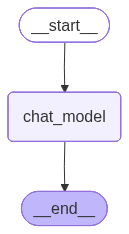

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching AI?
================================ Human Message =================================
Name: Paddy

Yes, I know about AI. But what others should I learn about?
================================== Ai Message ==================================

Nice question. If you already know AI, here are complementary domains that汇 strengthen what you can do and open new possibilities. Pick a couple that align with your goals and dive in.

- Statistics and Applied Math
  - What it covers: probability, inference, regression, experimental design, optimization.
  - Why it matters: improves model evaluation, uncertainty quantification, and how you reason about data.

- Data Engineering, Databases, and Data Quality
  - What it covers: data pipelines, ETL, SQL, data modeling, data governance.
  - Why it matters: clean, scalable data is the foundation for reliable AI systems.

- Computer

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

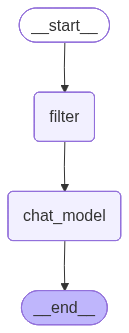

In [11]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Paddy", id="2"))
messages.append(AIMessage("So you said you were researching AI?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about AI. But what others should I learn about?", name="Paddy", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are a variety of other fascinating ocean mammals you might be interested in learning about. Here are a few:

1. **Dolphins**: These highly intelligent and social animals are part of the cetacean family, which also includes whales and porpoises. There are many species of dolphins, including the common bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and teeth. The harbor porpoise is one of the more well-known sp

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

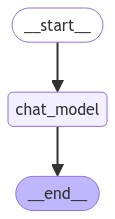

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [13]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://docs.langchain.com/oss/python/langgraph/add-memory#trim-messages), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

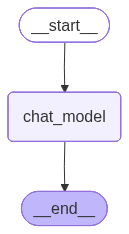

In [12]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [17]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [18]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r